# Libraries 

In [1]:
#Import libraries for text import
import glob
import os
import os,codecs

#Import libraries for generating word clouds
import wordcloud


#Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import libraries for developing database 
import pandas as pd
import numpy as np
from datetime import datetime
import re


#Import libraries for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.collocations import *
from nltk.draw.dispersion import dispersion_plot
nltk.download('stopwords')
from textblob import TextBlob #If you don't have TextBlob: conda install -c conda-forge textblob

#Import libraries for plotting on maps
import plotly.express as ex #If you don't have this library: $ pip install plotly==5.1.0 or $ conda install -c plotly plotly=5.1.0
import plotly.graph_objs as go
import plotly.figure_factory as ff

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Creating a data frame

In [2]:
files =[]
for dirname, _, filenames in os.walk('/Users/antoniya/Desktop/Documents/uni_stuff/FU/Programming/Trump Project/kaggle_data'):
    for filename in filenames:
        with open((os.path.join(dirname, filename))) as w: files.append(w.read())

f_names = [f.replace('.txt','') for f in filenames]
months = ['Jan','Feb','Mar','Apr','May','Jul','Jun','Aug','Sep','Oct','Nov','Dec']
city,r_month,date = [],[],[]
for name in f_names:
    index= -1
    for month in months:
        index =name.find(month)
        if index != -1:
            r_month.append(month)
            break
    city.append(name[:index])
    date.append(name[index+3:])

    
    
rallies_df = pd.DataFrame({'Month':r_month,'Year':date,'City':city,'Speech':files})
rallies_df['Day'] = rallies_df['Year'].apply(lambda x: x.split('_')[0])
rallies_df['Year'] = rallies_df['Year'].apply(lambda x: x.split('_')[1])
rallies_df = rallies_df[['Day','Month','Year','City','Speech']]
rallies_df['City'] = rallies_df['City'].apply(lambda x:  ' '.join(re.sub( r"([A-Z])", r" \1", x).split()))
rallies_df['Speech'] = rallies_df['Speech'].apply(lambda x: x.strip().lower())

#Put a variable with all of the states
rallies_df['State'] = ['North Carolina','Mississippi','New Hampshire','Nevada', 'Ohio', 'Arizona', 'Michigan', 'Pennsylvania', 'Texas','Colorado', 'Pennsylvania', 'Texas', 'Iowa', 'Minnesota', 'Arizona', 'Ohio','North Carolina', 'North Carolina', 'Oklahoma', 'New Mexico', 'Pennsylvania', 'New Hampshire', 'Nevada', 'New Hampshire', 'Louisiana', 'Michigan', 'South Carolina', 'Wisconsin', 'Wisconsin','Kentucky', 'Minnesota', 'Ohio', 'North Carolina', 'New Jersey', 'South Carolina']

# Data Preprocessing

In [3]:
#First step tokenize
rallies_df['tokenized_speech'] = rallies_df['Speech'].apply(word_tokenize)

#Stopwords and punctuation filtering 
stopWords = set(stopwords.words('english')) 
rallies_df['filtered_speech'] = rallies_df['tokenized_speech'].apply(lambda x: [item for item in x if item not in stopWords if item.isalpha()])
rallies_df['most_common_20'] = ""
rallies_df['token_tagged'] = ""
rallies_df['most_common_content_20'] = ""

#Find 100 most common words for each speech and tag each token
x = list(range(0,len(rallies_df['filtered_speech'].index)))
for i in x: 
    rallies_df['most_common_20'].iloc[i] = FreqDist(rallies_df['filtered_speech'].iloc[i]).most_common(20)
    rallies_df['token_tagged'].iloc[i] = nltk.pos_tag(rallies_df['filtered_speech'].iloc[i])

#Extract only content words find 100 most common content words
rallies_df['content_words_only'] = [[]]* len(rallies_df)
for i, row in rallies_df.iterrows():
    elements = row['token_tagged']
    selected = list()
    for el in elements:
        if el[1].startswith('N') or el[1].startswith('J') or el[1].startswith('RB') or el[1].startswith('V'):
            selected.append(el[0])
    rallies_df.at[i, 'content_words_only'] = selected
    rallies_df['most_common_content_20'].iloc[i] = FreqDist(rallies_df['content_words_only'].iloc[i]).most_common(20)
    


# Creating a string of the filtered data to do sentiment analysis

In [4]:
# Python program to convert a list to string   
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele + " "
    
    # return string  
    return str1 
        
        
# Testing code    
s = ['Geeks', 'for', 'Geeks']
print(listToString(s)) 

Geeks for Geeks 


In [5]:
for i in x:
    a = listToString(rallies_df['content_words_only'][i])
    rallies_df.at[i, 'fully_filtered_speech'] = a
    


# Visualising data frame before Sentiment Analysis

In [ ]:
rallies_df.head()    

# Sentiment Analysis
Vader, TextBlob, SentiArt

In [6]:
#Initialize sentiment analyzer
###Vader###
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
rallies_df['sentiments_VADER'] = rallies_df['fully_filtered_speech'].apply(lambda x: sid.polarity_scores(x))
rallies_df['Positive Sentiment_VADER'] = rallies_df['sentiments_VADER'].apply(lambda x: x['pos']) 
rallies_df['Neutral Sentiment_VADER'] = rallies_df['sentiments_VADER'].apply(lambda x: x['neu'])
rallies_df['Negative Sentiment_VADER'] = rallies_df['sentiments_VADER'].apply(lambda x: x['neg'])
rallies_df.drop(columns=['sentiments_VADER'],inplace=True)

###TextBlob###
from textblob import TextBlob 
polarity = []
subjectivity = []
for i in x:
    blob = TextBlob(rallies_df['fully_filtered_speech'][i])
    [p, s] = blob.sentiment
    polarity.append(p)
    subjectivity.append(s)

rallies_df['Polarity_TextBlob'] = polarity
rallies_df['Subjectivity_TextBlod'] = subjectivity

###SentiArt###
TC = '/Users/antoniya/Desktop/Documents/uni_stuff/FU/Programming/Trump Project/SentiArt-main/250kSentiArt_EN.xlsx' # for English texts
#TC = '120kSentiArt_DE.xlsx' # for German texts
sa = pd.read_excel(TC) #    

#compute mean AAP (or mean fear etc.) per sentence
sent_mean_AAPz = [];sent_mean_fear_z = []; sent_mean_ang_z = []; sent_mean_hap_z = []

for i in x:
    token = rallies_df.content_words_only.iloc[i]
    dt = sa.query('word in @token')
    sent_mean_AAPz.append(dt.AAPz.mean())
    sent_mean_fear_z.append(dt.fear_z.mean())
    sent_mean_ang_z.append(dt.ang_z.mean())
    sent_mean_hap_z.append(dt.hap_z.mean())

rallies_df['AAPz_SentiArt'] =  sent_mean_AAPz
rallies_df['Mean_fear_z_SentiArt'] = sent_mean_fear_z
rallies_df['Mean_ang_z_SentiArt'] = sent_mean_ang_z
rallies_df['Mean_hap_z_SentiArt'] = sent_mean_hap_z

# Exploration if the Sentiment Analysis outcome

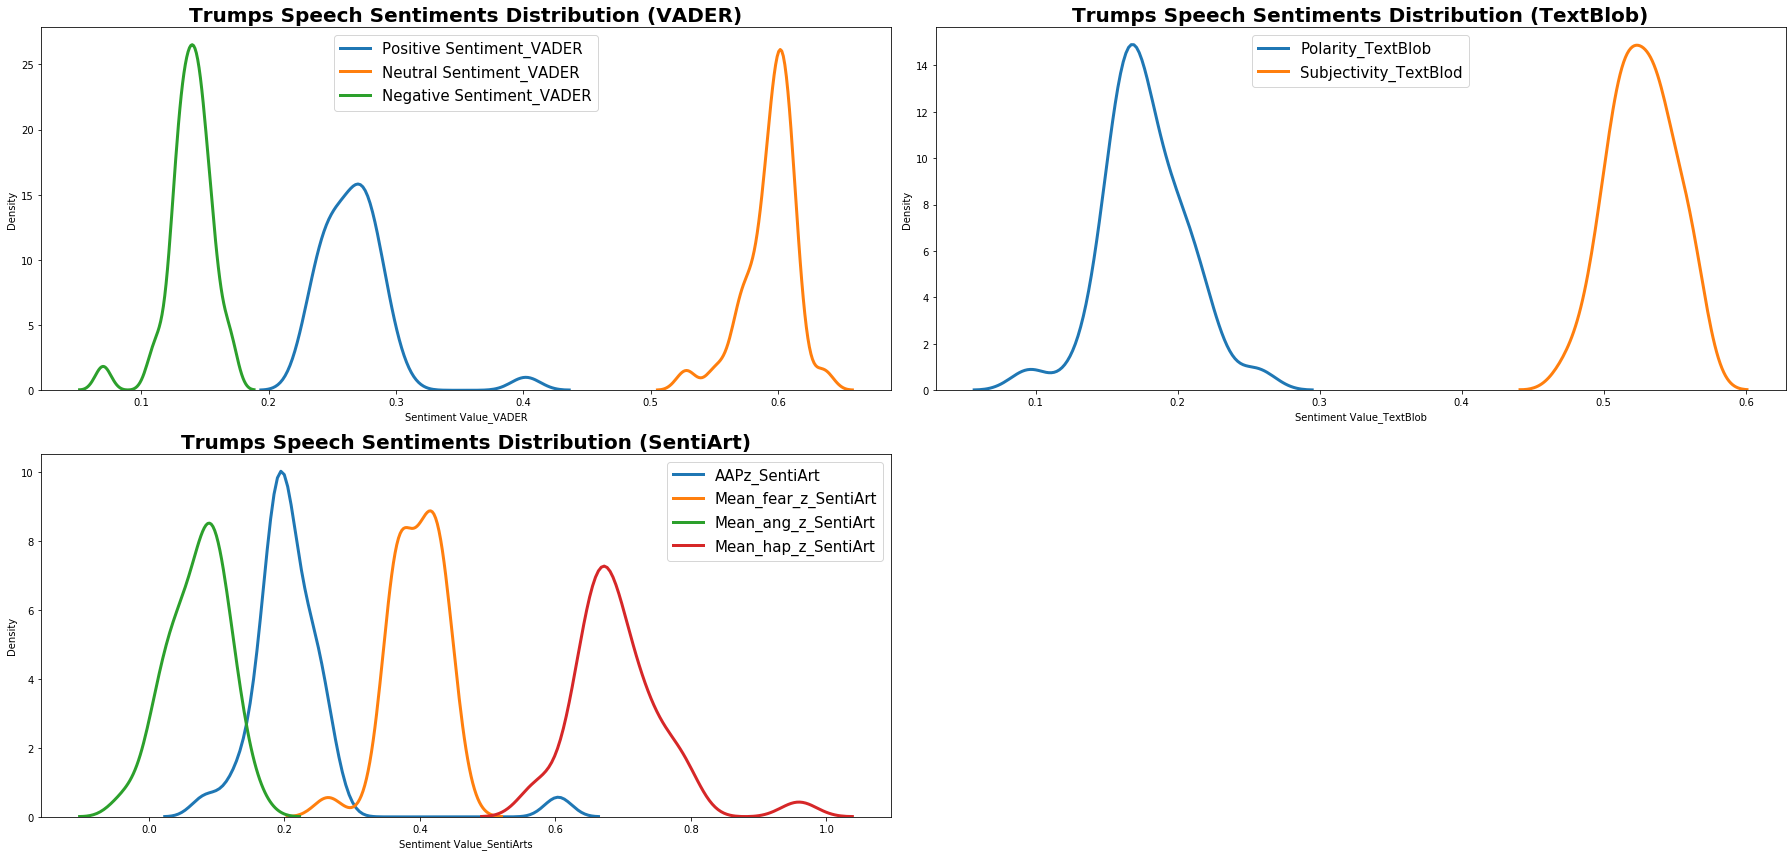

In [7]:
f = plt.figure(figsize=(25,12))


ax = f.add_subplot(221)
ax = sns.kdeplot(rallies_df['Positive Sentiment_VADER'],lw=3)
ax = sns.kdeplot(rallies_df['Neutral Sentiment_VADER'],lw=3)
ax = sns.kdeplot(rallies_df['Negative Sentiment_VADER'],lw=3)
ax.set_xlabel('Sentiment Value_VADER',fontsize=10)
ax.set_ylabel('Density',fontsize=10)
ax.set_title('Trumps Speech Sentiments Distribution (VADER)',fontsize=20,fontweight='bold')
plt.legend(prop=dict(size=15))


ax2 = f.add_subplot(222)
ax2 = sns.kdeplot(rallies_df['Polarity_TextBlob'],lw=3)
ax2 = sns.kdeplot(rallies_df['Subjectivity_TextBlod'],lw=3)
ax2.set_xlabel('Sentiment Value_TextBlob',fontsize=10)
ax2.set_ylabel('Density',fontsize=10)
ax2.set_title('Trumps Speech Sentiments Distribution (TextBlob)',fontsize=20,fontweight='bold')
plt.legend(prop=dict(size=15))
plt.tight_layout()

ax3 = f.add_subplot(223)
ax3 = sns.kdeplot(rallies_df['AAPz_SentiArt'],lw=3)
ax3 = sns.kdeplot(rallies_df['Mean_fear_z_SentiArt'],lw=3)
ax3 = sns.kdeplot(rallies_df['Mean_ang_z_SentiArt'],lw=3)
ax3 = sns.kdeplot(rallies_df['Mean_hap_z_SentiArt'],lw=3)
ax3.set_xlabel('Sentiment Value_SentiArts',fontsize=10)
ax3.set_ylabel('Density',fontsize=10)
ax3.set_title('Trumps Speech Sentiments Distribution (SentiArt)',fontsize=20,fontweight='bold')
plt.legend(prop=dict(size=15))
plt.tight_layout()

# WordClouds

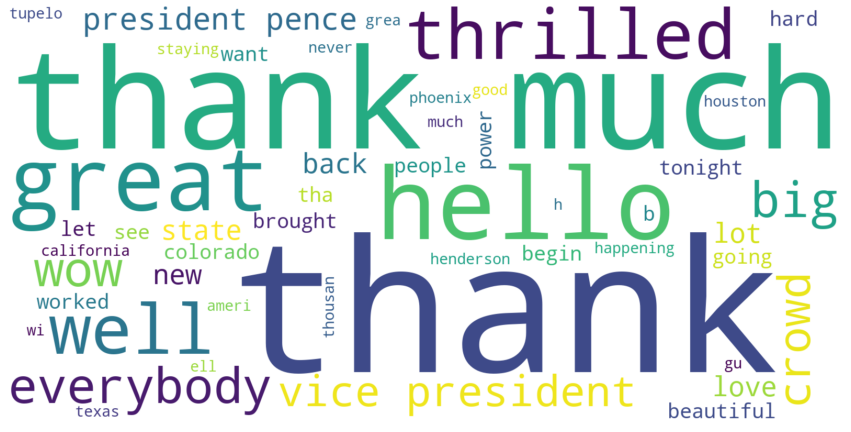

In [60]:
#A wordlcloud for all the speeches combined 
from wordcloud import WordCloud,STOPWORDS

text = str(rallies_df['fully_filtered_speech'].astype(str))
wordcloud = WordCloud(max_words = 50, width = 1600, height = 800, background_color ='white').generate(text)

plt.figure(figsize = (15, 15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

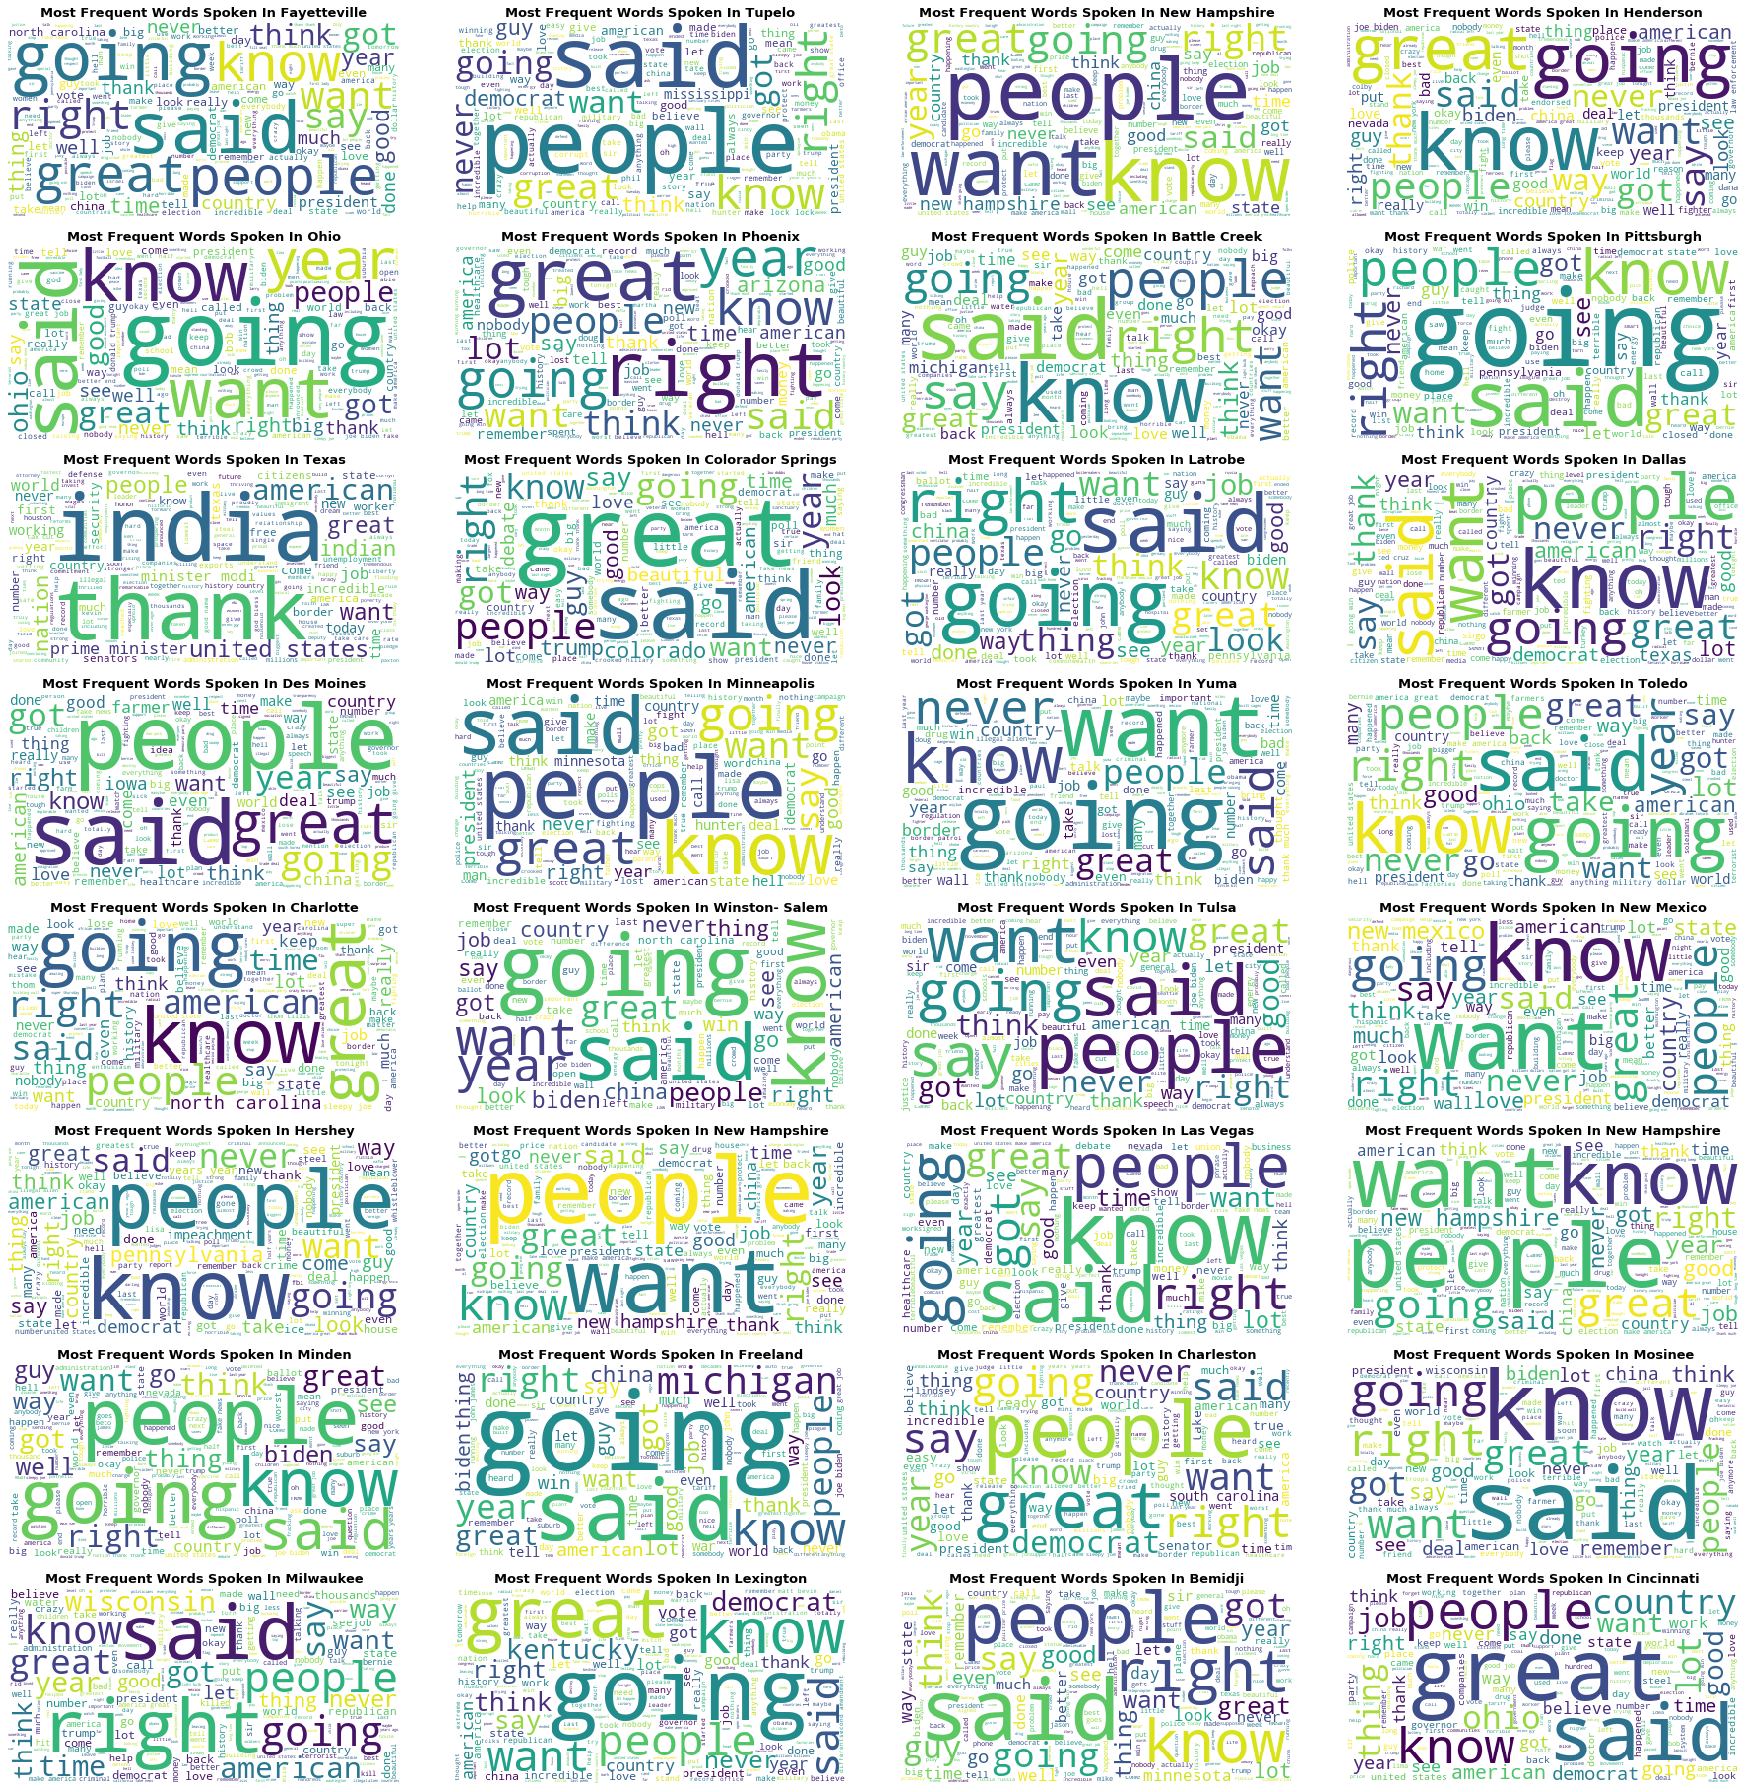

In [9]:
#Worldclouds per City
fig,axes = plt.subplots(8,4)
fig.set_figwidth(25)
fig.set_figheight(25)
r,c=0,0

for cit in rallies_df.City:
    text = rallies_df.query('City == "{}"'.format(cit))
    text = ' '.join(text.fully_filtered_speech.values)
    axes[r][c].imshow(WordCloud(background_color ='white', stopwords=STOPWORDS).generate(text))
    axes[r][c].axis('off')
    axes[r][c].set_title('Most Frequent Words Spoken In {}'.format(cit),fontsize=13,fontweight='bold')
    c+=1
    if c == 4:
        c = 0
        r+=1
    if r == 8:
        break
plt.tight_layout()

# Creating choropleth maps

In [10]:
import plotly.express as px

states = ["AL - Alabama", "AK - Alaska", "AZ - Arizona", "AR - Arkansas", "CA - California", "CO - Colorado",
"CT - Connecticut", "DC - Washington DC", "DE - Deleware", "FL - Florida", "GA - Georgia",
"HI - Hawaii", "ID - Idaho", "IL - Illinios", "IN - Indiana", "IA - Iowa",
"KS - Kansas", "KY - Kentucky", "LA - Louisiana", "ME - Maine", "MD - Maryland",
"MA - Massachusetts", "MI - Michigan", "MN - Minnesota", "MS - Mississippi",
"MO - Missouri", "MT - Montana", "NE - Nebraska", "NV - Nevada", "NH - New Hampshire",
"NJ - New Jersey", "NM - New Mexico", "NY - New York", "NC - North Carolina",
"ND - North Dakota", "OH - Ohio", "OK - Oklahoma", "OR - Oregon", "PA - Pennsylvania",
"RI - Rhode Island", "SC - South Carolina", "SD - South Dakota", "TN - Tennessee",
"TX - Texas", "UT - Utah", "VT - Vermont", "VA - Virgina", "WA - Washington", "WV - West Virginia",
"WI - Wisconsin", "WY - Wyoming"]
states = {s.split(' - ')[1]:s.split(' - ')[0] for s in states}

r_df = rallies_df.copy()
r_df['State'] = r_df['State'].apply(lambda x: states[x])
r_df = r_df.groupby(by='State').mean()
r_df = r_df.reset_index()

fig = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Positive Sentiment_VADER' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
fig.update_layout(title = "How Positive Was The Speech At Each State (Vader)")
fig.show()

fig1 = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Negative Sentiment_VADER' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
fig1.update_layout(title = "How Negative Was The Speech At Each State (Vader)")
fig1.show()



In [59]:
#TextBlob outputs across the states
fig = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Polarity_TextBlob' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
fig.update_layout(title = "How Polarised Was The Speech At Each State (TextBlob)")
fig.show()

fig1 = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Subjectivity_TextBlod' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
fig1.update_layout(title = "How Subjective Was The Speech At Each State (TextBlob)")
fig1.show()

In [11]:
fig = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='AAPz_SentiArt' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
fig.update_layout(title = "How Affective Was The Speech At Each State (SentiArt)")
fig.show()

In [12]:
#SentiArt outputs across the states
ax = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Mean_hap_z_SentiArt' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
ax.update_layout(title = "How Happy Was The Speech At Each State (SentiArt)")
ax.show()


ax2 = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Mean_ang_z_SentiArt' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
ax2.update_layout(title = "How Angry Was The Speech At Each State (SentiArt)")
ax2.show()

ax3 = ex.choropleth(r_df,locations ='State', locationmode="USA-states",color ='Mean_fear_z_SentiArt' , scope="usa",color_continuous_scale=ex.colors.diverging.Portland)
ax3.update_layout(title = "How Fearful Was The Speech At Each State (SentiArt)")
ax3.show()

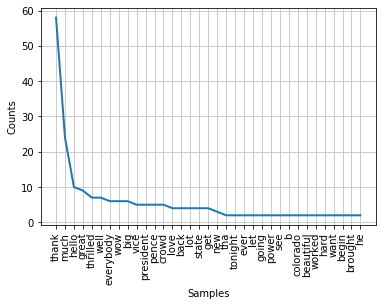

Text(0.5, 1.0, '20 Most common words across all speeches')

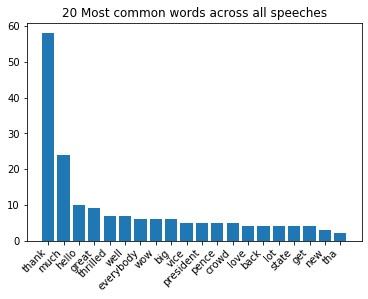

In [58]:
#Frequeny Distribution across all speeches
import string
text = str(rallies_df['fully_filtered_speech'].astype(str))
text.translate(str.maketrans('', '', string.punctuation))
text = ''.join([i for i in text if not i.isdigit() if i not in ('...')])
text = word_tokenize(text)
FreqDist(text).plot(35)
    
text1 = FreqDist(text).most_common(20)
words = []
counts = []

for i in list(range(0, len(text1))):
    a = text1[i][0]
    b = text1[i][1]
    words.append(a)
    counts.append(b)

plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 Most common words across all speeches')